Esse código foi desenvolvido para lidar com problemas de classificação binária (duas classes). 
Esse pepiline cobre as etapas de normalização dos dados, balanceamento de classes, cross-validation, seleção das features, previsão das classes utilizando modelos de machine learning (KNN/SVM/RANDOM FOREST), e validação do modelo considerando diferentes métricas de avaliação (Accuracy, sensitivity, specificity, f1-score and auc).
Observe que, antes de utilizar esse código, é necessário realizar etapas de pré-processamentos de dados, como por exemplo, limpeza dos dados (missing data, noise elimination, tratamento de outliers), transformação dos dados (codificação de dados categóricos (one-hot-encoding)), criação de novas variáveis se for o caso, e transformar a variável a ser prevista em 0 e 1 para cada classe a ser prevista.
A base de dados que utilizei para testar a funcionalidade do código já está pré-processada e é uma base de dados de acesso privado.

In [1]:
#-------------------------------------------------------
#  BIBLIOTECAS
#-------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
#from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

from imblearn.under_sampling import RandomUnderSampler, InstanceHardnessThreshold
from imblearn.over_sampling import RandomOverSampler, SMOTE
import optuna

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)







from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

c:\Users\carol\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PLOTANDO GRÁFICO DE PROPORÇÕES DAS CLASSES

Esta função foi desenvolvida para gerar um gráfico que evidencia as proporções, em percentagem (%), do desbalanceamento entre as classes. Isso permite identificar se é necessário aplicar a função "balanceamento", que é apresentada posteriormente neste código.

Exemplo de Utilização:
Suponha que você tenha um DataFrame denominado "df" com uma coluna para a variável de resposta chamada "CLASSES". Para utilizar a função, siga este exemplo:

plot_countplot_with_proportions(df, "CLASSES")

In [2]:
#-------------------------------------------------------
#  PLOTANDO DAS CLASSES PARA EVIDENCIAR AS PROPORÇÕES
#-------------------------------------------------------

def plot_classes_with_proportions(df, target_column):
    # Crie o countplot
    ax = sns.countplot(x=target_column, data=df)

    # Calcule o número total de ocorrências
    total_occurrences = len(df)

    # Obtenha a contagem de ocorrências de cada classe
    class_count = df[target_column].value_counts()

    # Calcule as proporções em relação ao total de ocorrências de cada classe
    proportions = class_count / total_occurrences * 100

    # Exiba as proporções no gráfico
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{proportions[i]:.2f}%', ha='center')

    # Verifique se a proporção do desbalanceamento é menor que 40% e retorne 'true' ou 'false'
    if proportions.min() < proportionclass:
        return True
    else:
        return False

Nessa etapa é realizada a leitura dos dados e definido alguns parâmetros do código

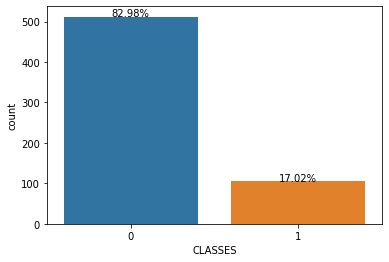

In [3]:
#-------------------------------------------------------
#  LEITURA DOS DADOS E ALGUNS PARÂMETROS DO CÓDIGO
#-------------------------------------------------------
#BASE DE DADOS:
df = pd.read_csv("C:/Users/carol/Dropbox/UFRGS/python portfolio/df_pre_processado.csv")
#COLUNA DA BASE DE DADOS QUE CORRESPONDE A VARIÁVEL A SER PREVISTA:
target_column = 'CLASSES'
#TÉCNICA DE ESCALONAMENTO A SER UTILIZADA:
#opções = 'min_max', 'z_score'
scaling_method = 'min_max'
#PROPORÇÃO (%) DE DESBALANCEAMENTO ENTRE AS CLASSES ACEITÁVEL PARA A NÃO APLICAÇÃO DE TÉCNICAS QUE REALIZAM O BALANCEAMENTO DOS DADOS
proportionclass = 40
# CASO OS DADOS ESTEJAM DESBALANCEADOS, imbalanced_classes IRÁ RETORNAR O PARÂMETRO 'true' QUE PERMITE QUE O CÓDGIO FAÇA O BALANCEAMENTO:
#opções = 'true', 'false'
imbalanced_classes = plot_classes_with_proportions(df, target_column)
# CASO OS DADOS ESTEJAM DESBALANCEADOS, ESCOLHA A TÉCNICA PARA BALANCEAMENTO DOS DADOS:
#opções = 'RandomUnderSampler', 'InstanceHardnessThreshold', 'RandomOverSampler', 'SMOTE'
res_technique = 'InstanceHardnessThreshold'

Função que separa as variáveis independentes (x1, x2,..., xn) da variável de resposta (y)

Exemplo de uso:
Supondo que você tenha um DataFrame chamado 'df' com a coluna alvo chamada 'column'. Para utilizar a função, siga este exemplo:

df_x, df_y = split_df_into_target_and_features(df, target_column)

In [4]:
def split_df_into_target_and_features(df, target_column):
    df_y = df[target_column]
    df_y= df_y.to_numpy()
    df_x = df.drop(target_column, axis=1)
    return df_x, df_y

NORMALIZAÇÃO OU PADRONIZAÇÃO

O escalonamento é feito para assegurar que todos os dados estejam na mesma escala, facilitando a comparação entre diferentes variáveis.
Na normalização ('min_max') os valores são ajustados para um intervalo específico, como 0 e 1.
A padronização ('z_score') é o processo de transformar os dados de forma que eles tenham uma média de 0 e um desvio padrão de 1.

Na função abaixo, você pode passar o parâmetro method para escolher entre 'min_max' e 'z_score' para indicar o tipo de escalonamento desejado. 
Se um método não reconhecido for fornecido, a função lançará um erro. 

Exemplo de uso da função:
Supondo que você tenha um dataframe "x" que contenha todas as suas variáveis independentes e escolha utilizar o método 'min_max' que cria uma escala entre 0 e 1 em todos os seus dados. Você pode chamar a função assim:

x_normalized = normaliz(x, 'min_max')

Caso queira fazer o processo de padronização dos dados: 

x_normalized = normaliz(x, 'z_score')

In [5]:
#---------------------------------------------------------
#  Escalonamento: NORMALIZAÇÃO ou PADRONIZAÇÃO
#---------------------------------------------------------

def scaling(df_x, scaling_method):
    if scaling_method == 'min_max':
        min_max_scaler = MinMaxScaler(feature_range=(0,1))
        x_normalized = min_max_scaler.fit_transform(df_x)
        return x_normalized
    elif scaling_method == 'z_score':
        z_scaler = StandardScaler()
        x_normalized = z_scaler.fit_transform(df_x)
        return z_scaler
    else:
        raise ValueError("Método de normalização não reconhecido. Use 'min_max' ou 'z_score'.")   

MÉTRICAS DE AVALIAÇÃO DOS DADOS

Por se tratar de um problema de classificação, diferentes métricas podem ser utilizadas para avaliar os resultados da classificação:

*Acurácia: Mede a proporção de previsões corretas em relação ao total de previsões.

*Precisão: Mede a proporção de verdadeiros positivos em relação ao total de previsões positivas.

*Recall ou sensibilidade: Mede a proporção de verdadeiros positivos em relação ao total de casos positivos reais.

*F1-Score: Combina precisão e recall em uma única medida que equilibra o trade-off entre eles, através de uma média harmônica.

*Área sob a Curva ROC (AUC): Avalia a capacidade do modelo de distinguir entre classes positivas e negativas em um problema de classificação binária. Quanto maior, melhor a capacidade de discriminação do modelo.

Exemplo de Utilização da Função:
Suponha que os dados de entrada sejam os dados reais de saída esperada (y_true) e os dados previstos pelo algoritmo (y_pred). Para chamar a função, proceda da seguinte maneira:

acuracia, precisao, recall, f1_score, auc = classification_metrics(y_true, y_pred)

In [6]:
#---------------------------------------------------------
#  METRICAS DE AVALIAÇÃO DOS DADOS
#---------------------------------------------------------
# os dados de entrada são os dados reais de saída (y_true) e os dados previstos para as respectivas saídas (y_pred)
def classification_metrics(y_true, y_pred):

    # Calcula as métricas individualmente
    acuracia = sklearn.metrics.accuracy_score(y_true, y_pred)
    precisao = sklearn.metrics.precision_score(y_true, y_pred)
    recall = sklearn.metrics.recall_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    auc = sklearn.metrics.roc_auc_score(y_true, y_pred)
    #retorna todas as métricas calculadas
    return acuracia, precisao, recall, f1_score, auc

BALANCEAMENTO DOS DADOS

O balanceamento de dados é uma etapa crucial no pré-processamento de dados, onde desequilíbrios nas classes podem levar a resultados enviesados ou modelos com desempenho inadequado. 
Existem várias abordagens para o balanceamento de dados no nível dos dados:

RandomUnderSampler: seleciona aleatoriamente um subconjunto das instâncias da classe majoritária (para ser descartadas) para igualar o número de instâncias da classe minoritária.

InstanceHardnessThreshold: usa uma medida de "dureza" para determinar quais instâncias são mais difíceis de classificar corretamente. Ele remove as instâncias mais "fáceis" da classe majoritária, com base nessa medida, para tentar equilibrar as classes.

RandomOverSampler: Ao contrário do RandomUnderSampler, este método replica aleatoriamente instâncias da classe minoritária até que o número de instâncias de ambas as classes seja equilibrado.

SMOTE (Synthetic Minority Over-sampling Technique): gera instâncias sintéticas da classe minoritária, criando novos exemplos interpolados entre instâncias existentes. 

In [7]:
#---------------------------------------------------------
#  BALANCEAMENTO DOS DADOS
#---------------------------------------------------------
def resampling(df_x, df_y, res_technique):
    if res_technique == 'RandomUnderSampler':
        balancer = RandomUnderSampler()
    elif res_technique == 'InstanceHardnessThreshold':
        balancer = InstanceHardnessThreshold()
    elif res_technique == 'RandomOverSampler':
        balancer = RandomOverSampler()
    elif res_technique == 'SMOTE':
        balancer = SMOTE()
    else:
        raise ValueError('Técnica de balanceamento não reconhecida.')
    
    balanced_x, balanced_y = balancer.fit_resample(df_x, df_y)
    counts = np.bincount(balanced_y)
    
    return balanced_x, balanced_y

A função de Balanceamento dos dados criada anteriormente, só é aplicada se o desbalanceamento nos dados for verdadeiro.

In [8]:
#---------------------------------------------------------
#  BALANCEAMENTO DOS DADOS, se 'imbalanced_classes' for 'true'
#---------------------------------------------------------

# Função para resample dos dados caso 'imbalanced_classes' seja 'true'
def resampling_if_imbalanced_classes_is_true(X_train, y_train, res_technique, imbalanced_classes):
    if imbalanced_classes == True:
        # Aplique a função criada anteriormente, de resampling tecnique, apenas no conjunto de treinamento do fold atual
        balanced_x, balanced_y = resampling(X_train, y_train, res_technique)
        return balanced_x, balanced_y
    
    else:
        return X_train, y_train


Optuna é uma biblioteca Python robusta e de código aberto desenvolvida para simplificar a otimização de hiperparâmetros no aprendizado de máquina. Ele oferece uma interface intuitiva para otimizar hiperparâmetros, permitindo que você explore com eficiência o vasto espaço de pesquisa e determine a configuração ideal para o seu modelo. A principal funcionalidade do Optuna reside em sua capacidade de procurar automaticamente os melhores hiperparâmetros através de vários algoritmos de otimização e estratégias de poda.

In [9]:
def objective_knn(trial, df_x, df_y):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 15, step=2)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

    cv_scores = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(df_x, df_y):
        X_train_fold, X_val_fold = df_x[train_index], df_x[val_index]
        y_train_fold, y_val_fold = df_y[train_index], df_y[val_index]
        
        # Aplicando a função criada anteriormente, de resampling tecnique if_imbalanced_classes_is_true, apenas no conjunto de treinamento do fold atual
        returned_x, returned_y = resampling_if_imbalanced_classes_is_true(X_train_fold, y_train_fold, res_technique, imbalanced_classes)

        # Criando o modelo KNN com os hiperparâmetros
        model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        # Treinando o modelo no conjunto de treinamento, após aplicar resampling_if_imbalanced_classes_is_true
        model.fit(returned_x, returned_y)
        # Avaliando o modelo no conjunto de validação atual
        y_pred = model.predict(X_val_fold)

        # Calculando a métrica de avaliação (AUC) para este fold, (observe que eu deixei a métrica hardcodada nessa parte do código, é possível deixar isso mais flexível)
        f1 = sklearn.metrics.f1_score(y_val_fold, y_pred)
        # Armazene a métrica no fold atual
        cv_scores.append(f1)
    # Calcule a média das métricas de validação cruzada
    avg_cv_score = np.mean(cv_scores)

    return avg_cv_score


# def objective_svm(trial, df_x, df_y):
#     C = trial.suggest_loguniform('C', 0.1, 10)
#     kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])

#     model = SVC(C=C, kernel=kernel)

#     cv_scores = []
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#     for train_index, val_index in kf.split(df_x, df_y):
#         X_train_fold, X_val_fold = df_x[train_index], df_x[val_index]
#         y_train_fold, y_val_fold = df_y[train_index], df_y[val_index]

#         model.fit(X_train_fold, y_train_fold)
#         y_pred = model.predict(X_val_fold)

#         f1 = sklearn.metrics.f1_score(y_val_fold, y_pred)
#         cv_scores.append(f1)

#     avg_cv_score = np.mean(cv_scores)

#     return avg_cv_score


# def objective_randomforest(trial, df_x, df_y):
#     n_estimators = trial.suggest_int('n_estimators', 10, 100, step=10)
#     max_depth = trial.suggest_int('max_depth', 3, 10)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

#     model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)

#     cv_scores = []
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#     for train_index, val_index in kf.split(df_x, df_y):
#         X_train_fold, X_val_fold = df_x[train_index], df_x[val_index]
#         y_train_fold, y_val_fold = df_y[train_index], df_y[val_index]

#         model.fit(X_train_fold, y_train_fold)
#         y_pred = model.predict(X_val_fold)

#         f1 = sklearn.metrics.f1_score(y_val_fold, y_pred)
#         cv_scores.append(f1)

#     avg_cv_score = np.mean(cv_scores)

#     return avg_cv_score


In [10]:
def optimize_hyperparameters(df_x, df_y, model_type, n_trials):
    if model_type == 'KNN':
        objective = objective_knn
    elif model_type == 'SVM':
        objective = objective_svm
    elif model_type == 'RandomForest':
        objective = objective_randomforest
    #estudo Optuna com uma estratégia de poda
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(lambda trial: objective(trial, df_x, df_y), n_trials=n_trials)

    best_params = study.best_params

    return best_params

In [11]:
#aplicando as funções criadas anteriormente, primeiro para dividir o df em x(variáveis independentes) e y(variável dependente), e depois aplicando a função de escalonamento dos dados
df_x, df_y = split_df_into_target_and_features(df, target_column)
df_x = scaling(df_x, scaling_method)

In [12]:
best_params_knn = optimize_hyperparameters(df_x, df_y, 'KNN', n_trials=100)
# best_params_svm = optimize_hyperparameters(df_x, df_y, 'SVM', n_trials=40)
# best_params_randomforest = optimize_hyperparameters(df_x, df_y, 'RandomForest', n_trials=40)

print("Melhores parâmetros para KNN:", best_params_knn)
# print("Melhores parâmetros para SVM:", best_params_svm)
# print("Melhores parâmetros para RandomForest:", best_params_randomforest)

[I 2024-03-04 10:34:41,814] A new study created in memory with name: no-name-d9dcdea2-515e-48e4-a916-975ce34ad91b
[I 2024-03-04 10:34:44,808] Trial 0 finished with value: 0.3713501209275857 and parameters: {'n_neighbors': 1, 'metric': 'minkowski'}. Best is trial 0 with value: 0.3713501209275857.
[I 2024-03-04 10:34:47,569] Trial 1 finished with value: 0.3534844734844734 and parameters: {'n_neighbors': 1, 'metric': 'euclidean'}. Best is trial 0 with value: 0.3713501209275857.
[I 2024-03-04 10:34:50,312] Trial 2 finished with value: 0.4029450522595684 and parameters: {'n_neighbors': 5, 'metric': 'minkowski'}. Best is trial 2 with value: 0.4029450522595684.
[I 2024-03-04 10:34:52,874] Trial 3 finished with value: 0.3729896108965195 and parameters: {'n_neighbors': 11, 'metric': 'euclidean'}. Best is trial 2 with value: 0.4029450522595684.
[I 2024-03-04 10:34:55,440] Trial 4 finished with value: 0.3719571948998178 and parameters: {'n_neighbors': 11, 'metric': 'euclidean'}. Best is trial 2 w

Melhores parâmetros para KNN: {'n_neighbors': 7, 'metric': 'minkowski'}


In [13]:
best_params_knn

{'n_neighbors': 7, 'metric': 'minkowski'}

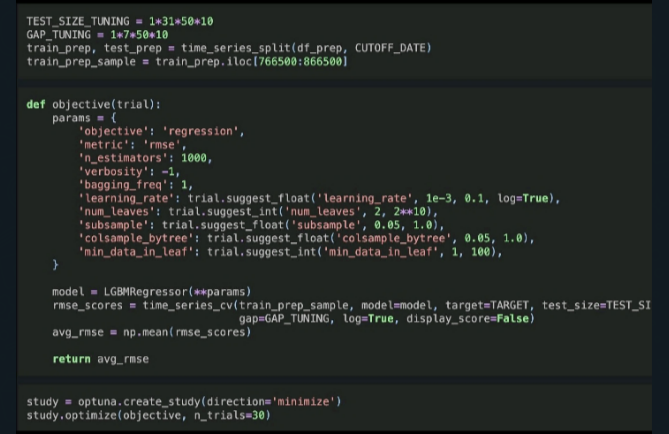

In [14]:
# #aplicando as funções criadas anteriormente, primeiro para dividir o df em x(variáveis independentes) e y(variável dependente), e depois aplicando a função de escalonamento dos dados
# df_x, df_y = split_df_into_target_and_features(df, target_column)
# df_x = scaling(df_x, scaling_method)

In [15]:
# def objective(trial):
#     # Defina os hiperparâmetros do algoritmo KNN que deseja otimizar:
#     n_neighbors = trial.suggest_int('n_neighbors', 1, 15, step=2)
#     metric = trial.suggest_categorical('metric', ['euclidean']) #, 'manhattan', 'minkowski'

#     # Inicializando uma lista para armazenar as métricas de validação cruzada
#     cv_scores = []

#     # Realizando a validação cruzada estratificada com K-fold (observe que eu deixei n_splits hardcodado nessa parte do código, é possível deixar isso mais flexível)
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#     for train_index, val_index in kf.split(df_x, df_y):
#         X_train_fold, X_val_fold = df_x[train_index], df_x[val_index]
#         y_train_fold, y_val_fold = df_y[train_index], df_y[val_index]
#         # Aplicando a função criada anteriormente, de resampling tecnique if_imbalanced_classes_is_true, apenas no conjunto de treinamento do fold atual
#         returned_x, returned_y = resampling_if_imbalanced_classes_is_true(X_train_fold, y_train_fold, res_technique, imbalanced_classes)

#         # Criando o modelo KNN com os hiperparâmetros
#         model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
#         # Treinando o modelo no conjunto de treinamento, após aplicar resampling_if_imbalanced_classes_is_true
#         model.fit(returned_x, returned_y)
#         # Avaliando o modelo no conjunto de validação atual
#         y_pred = model.predict(X_val_fold)

#         # Calculando a métrica de avaliação (AUC) para este fold, (observe que eu deixei a métrica hardcodada nessa parte do código, é possível deixar isso mais flexível)
#         auc = sklearn.metrics.roc_auc_score(y_val_fold, y_pred)
#         # Armazene a métrica no fold atual
#         cv_scores.append(auc)
#     # Calcule a média das métricas de validação cruzada
#     avg_cv_score = np.mean(cv_scores)

#     return avg_cv_score

In [16]:
# #---------------------------------------------------------
# #  OPTUNA PARA OTIMIZAÇÃO DOS PARÂMETROS DO ALGORITMO KNN
# #---------------------------------------------------------
# def optimize_knn_hyperparameters(df_x, df_y, n_trials):
#     # Create an Optuna study for hyperparameter optimization
#     study = optuna.create_study(direction='maximize')
#     study.optimize(objective, n_trials=n_trials)

#     # Retrieve the best hyperparameters from the Optuna study
#     best_params = study.best_params
#     best_n_neighbors = best_params['n_neighbors']
#     best_metric = best_params['metric']

#     return best_n_neighbors, best_metric

In [17]:
# #aplicando as funções criadas anteriormente, primeiro para dividir o df em x(variáveis independentes) e y(variável dependente), e depois aplicando a função de escalonamento dos dados
# df_x, df_y = split_df_into_target_and_features(df, target_column)
# df_x = scaling(df_x, scaling_method)

In [18]:
# # Usage:
# best_n_neighbors, best_metric = optimize_knn_hyperparameters(df_x, df_y, n_trials=20)